In [36]:
required_packages <- c("plgp", "lhs", "mvtnorm", "laGP", "hetGP")
install.packages(setdiff(required_packages, rownames(installed.packages())))

also installing the dependencies ‘maptree’, ‘tgp’, ‘DiceDesign’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



### 7.1.1 A running example

In [37]:
matrix((c(1, 1)), nrow=1)

1,1


In [38]:
f <- function(X)
 {
  if(is.null(nrow(X))) X <- matrix(X, nrow=1)
  m <- 8.6928
  s <- 2.4269
  x1 <- 4*X[,1] - 2
  x2 <- 4*X[,2] - 2
  a <- 1 + (x1 + x2 + 1)^2 * 
    (19 - 14*x1 + 3*x1^2 - 14*x2 + 6*x1*x2 + 3*x2^2)
  b <- 30 + (2*x1 - 3*x2)^2 * 
    (18 - 32*x1 + 12*x1^2 + 48*x2 - 36*x1*x2 + 27*x2^2)
  f <- log(a*b)
  f <- (f - m)/s
  return(f)
 }

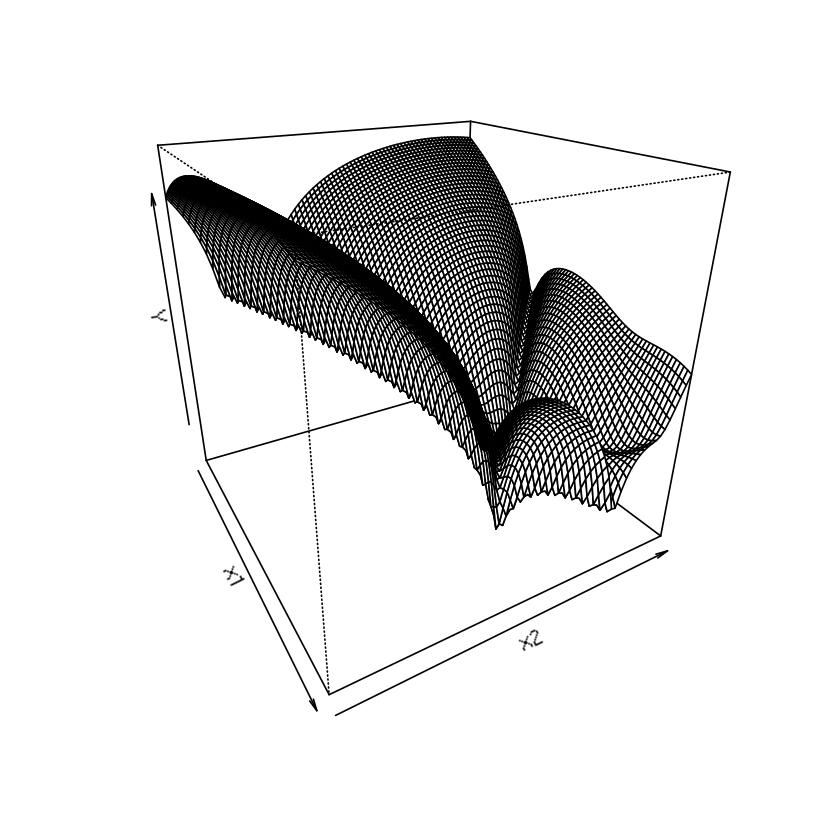

[1] -3.051809  5.062072

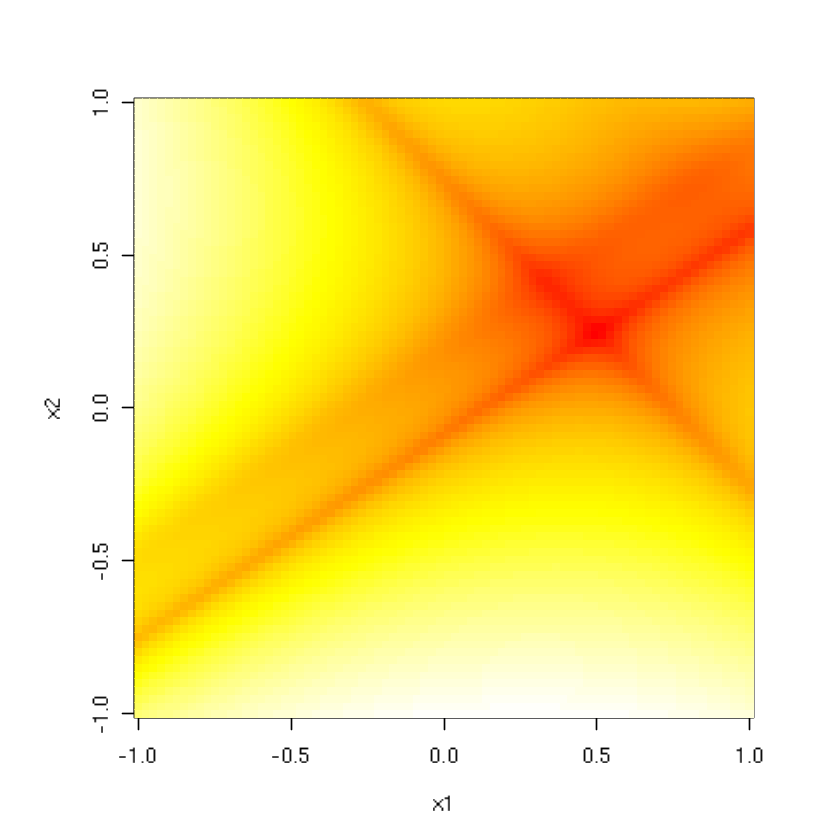

In [39]:
par(pty="s")
x1 <- x2 <- seq(-1, 1, length=80)
y <- f(expand.grid(x1, x2))
Y <- matrix(y, ncol=length(x2))
persp(x=x1, y=x2, z=Y, theta=60, phi=25)
image(x1, x2, Y, col=heat.colors(128))
range(y)

In [40]:
library(lhs)
ninit <- 12
X <- randomLHS(ninit, 2)
y <- f(X)
X
y

0.60658435,0.6742352233
0.97253229,0.5563143430
0.69571059,0.3652082746
0.02976576,0.9375733853
0.76014363,0.4250468651
0.46526904,0.1296921322
0.13144758,0.8493432690
0.90014885,0.2330450725
0.32591358,0.5963502938
0.57028430,0.7880634382
0.37192571,0.0003854149


[1] -0.2668260 -1.6987334 -1.6448951  1.8672877 -1.6975166 -0.4959473
 [7]  1.5622047  0.8644387  0.0410345  0.5790926  0.9320888 -0.6038535

In [41]:
library(laGP)
da <- darg(list(mle=TRUE, max=0.5), randomLHS(1000, 2))
gpi <- newGPsep(X, y, d=da$start, g=1e-6, dK=TRUE)
mleGPsep(gpi, param="d", tmin=da$min, tmax=da$max, ab=da$ab)$msg

[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

In [42]:
obj.mean <- function(x, gpi) 
  predGPsep(gpi, matrix(x, nrow=1), lite=TRUE)$mean

In [43]:
m <- which.min(y)
opt <- optim(X[m,], obj.mean, lower=0, upper=1, method="L-BFGS-B", gpi=gpi)
opt$par

[1] 0.5788056 0.3845750

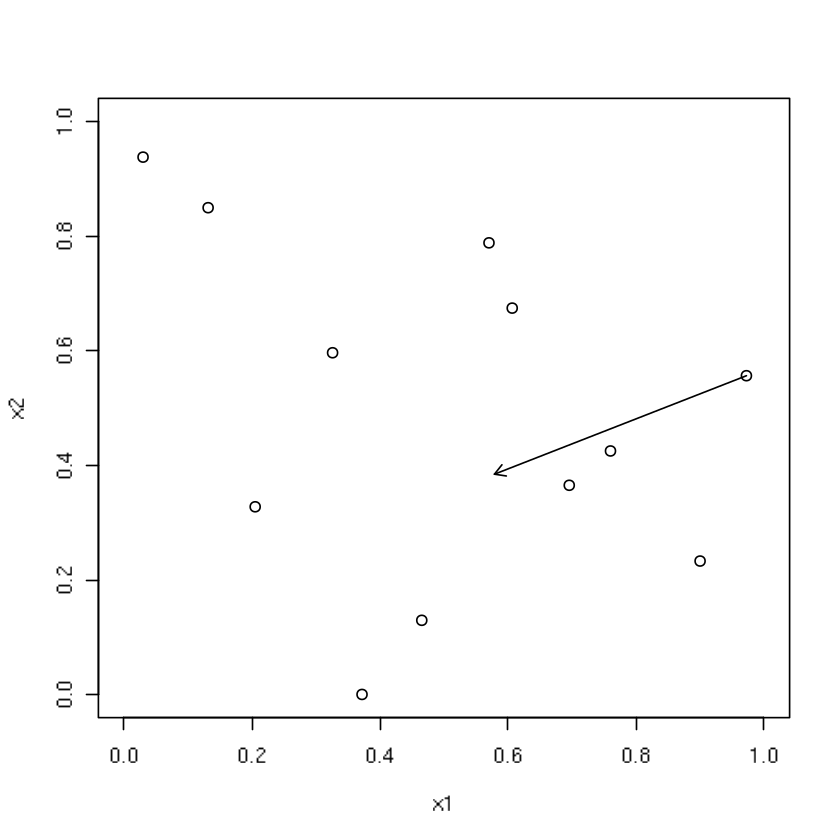

In [44]:
plot(X[1:ninit,], xlab="x1", ylab="x2", xlim=c(0,1), ylim=c(0,1))
arrows(X[m,1], X[m,2], opt$par[1], opt$par[2], length=0.1)

In [35]:
ynew <- f(opt$par)
updateGPsep(gpi, matrix(opt$par, nrow=1), ynew)
mle <- mleGPsep(gpi, param="d", tmin=da$min, tmax=da$max, ab=da$ab)
X <- rbind(X, opt$par)
y <- c(y, ynew)

In [36]:
m <- which.min(y)
opt <- optim(X[m,], obj.mean, lower=0, upper=1, method="L-BFGS-B", gpi=gpi)
opt$par

[1] 0.5201942 0.2700672

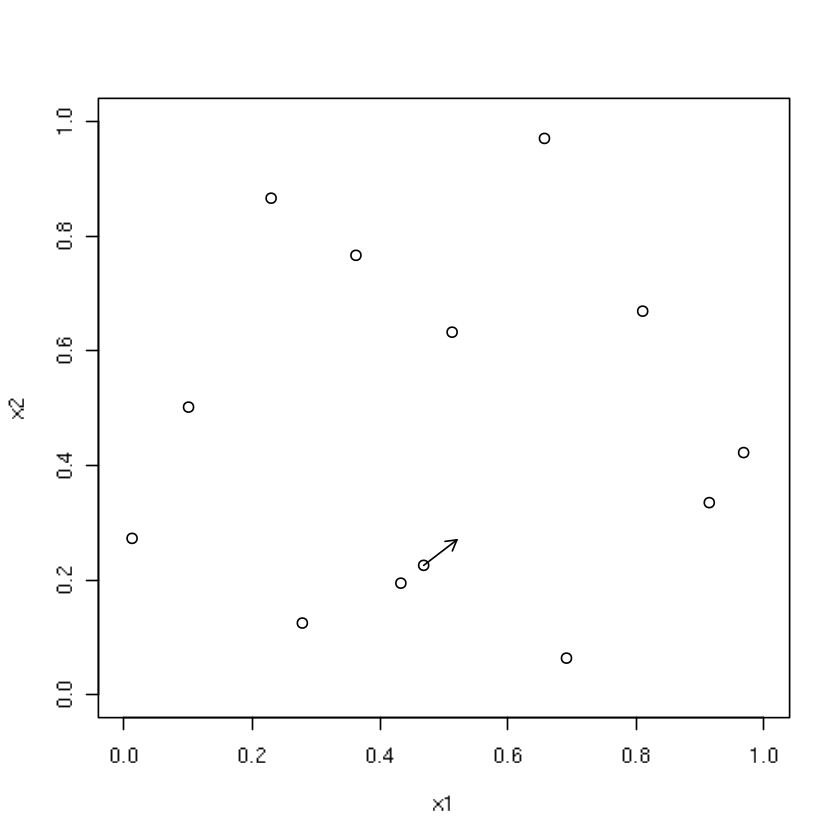

In [37]:
plot(X, xlab="x1", ylab="x2", xlim=c(0,1), ylim=c(0,1))
arrows(X[m,1], X[m,2], opt$par[1], opt$par[2], length=0.1)

In [38]:
ynew <- f(opt$par)
updateGPsep(gpi, matrix(opt$par, nrow=1), ynew)
mle <- mleGPsep(gpi, param="d", tmin=da$min, tmax=da$max, ab=da$ab)
X <- rbind(X, opt$par)
y <- c(y, ynew)

In [39]:
while(1) {
  m <- which.min(y)
  opt <- optim(X[m,], obj.mean, lower=0, upper=1, 
    method="L-BFGS-B", gpi=gpi)
  ynew <- f(opt$par)
  if(abs(ynew - y[length(y)]) < 1e-4) break
  updateGPsep(gpi, matrix(opt$par, nrow=1), ynew)
  mle <- mleGPsep(gpi, param="d", tmin=da$min, tmax=da$max, ab=da$ab)
  X <- rbind(X, opt$par)
  y <- c(y, ynew)
}
deleteGPsep(gpi)

In [40]:
bov <- function(y, end=length(y))
 {
  prog <- rep(min(y), end)
  prog[1:min(end, length(y))] <- y[1:min(end, length(y))]
  for(i in 2:end) 
    if(is.na(prog[i]) || prog[i] > prog[i-1]) prog[i] <- prog[i-1]
  return(prog)
 }

In [41]:
prog <- bov(y)

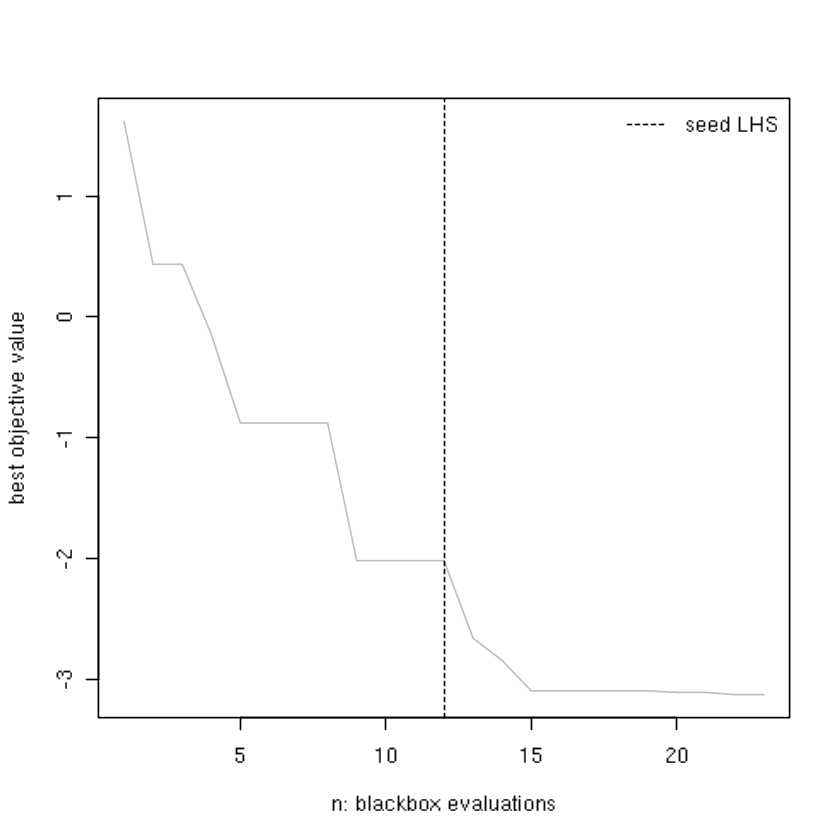

In [42]:
plot(prog, type="l", col="gray", xlab="n: blackbox evaluations", 
  ylab="best objective value")
abline(v=ninit, lty=2)
legend("topright", "seed LHS", lty=2, bty="n")

In [44]:
optim.surr <- function(f, m, ninit, end, tol=1e-4)
 {
  ## initialization
  X <- randomLHS(ninit, m)
  y <- f(X)
  da <- darg(list(mle=TRUE, max=0.5), randomLHS(1000, m))
  gpi <- newGPsep(X, y, d=da$start, g=1e-6, dK=TRUE)
  mleGPsep(gpi, param="d", tmin=da$min, tmax=da$max, ab=da$ab)

  ## optimization loop
  for(i in (ninit+1):end) {
    m <- which.min(y)
    opt <- optim(X[m,], obj.mean, lower=0, upper=1, 
      method="L-BFGS-B", gpi=gpi)
    ynew <- f(opt$par)
    if(abs(ynew - y[length(y)]) < tol) break
    updateGPsep(gpi, matrix(opt$par, nrow=1), ynew)
    mleGPsep(gpi, param="d", tmin=da$min, tmax=da$max, ab=da$ab)
    X <- rbind(X, opt$par)
    y <- c(y, ynew)
  }

  ## clean up and return
  deleteGPsep(gpi)
  return(list(X=X, y=y))
 }

In [45]:
reps <- 100
end <- 50
prog <- matrix(NA, nrow=reps, ncol=end)
for(r in 1:reps) {
  os <- optim.surr(f, 2, ninit, end)
  prog[r,] <- bov(os$y, end)
}

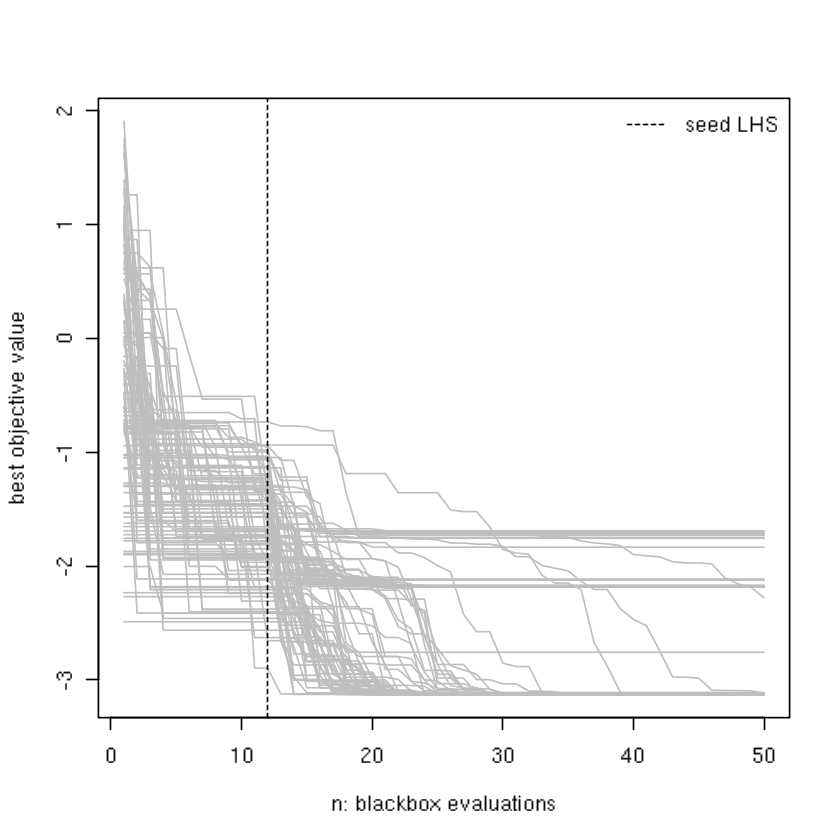

In [46]:
matplot(t(prog), type="l", col="gray", lty=1, 
  xlab="n: blackbox evaluations",  ylab="best objective value")
abline(v=ninit, lty=2)
legend("topright", "seed LHS", lty=2, bty="n")

### 7.1.2 A classical comparator

In [50]:
fprime <- function(x)
 {
  ynew <- f(x)
  y <<- c(y, ynew)
  return(ynew)
 }

In [51]:
prog.optim <- matrix(NA, nrow=reps, ncol=end)
for(r in 1:reps) {
  y <- c()
  os <- optim(runif(2), fprime, lower=0, upper=1, method="L-BFGS-B")
  prog.optim[r,] <- bov(y, end) 
}

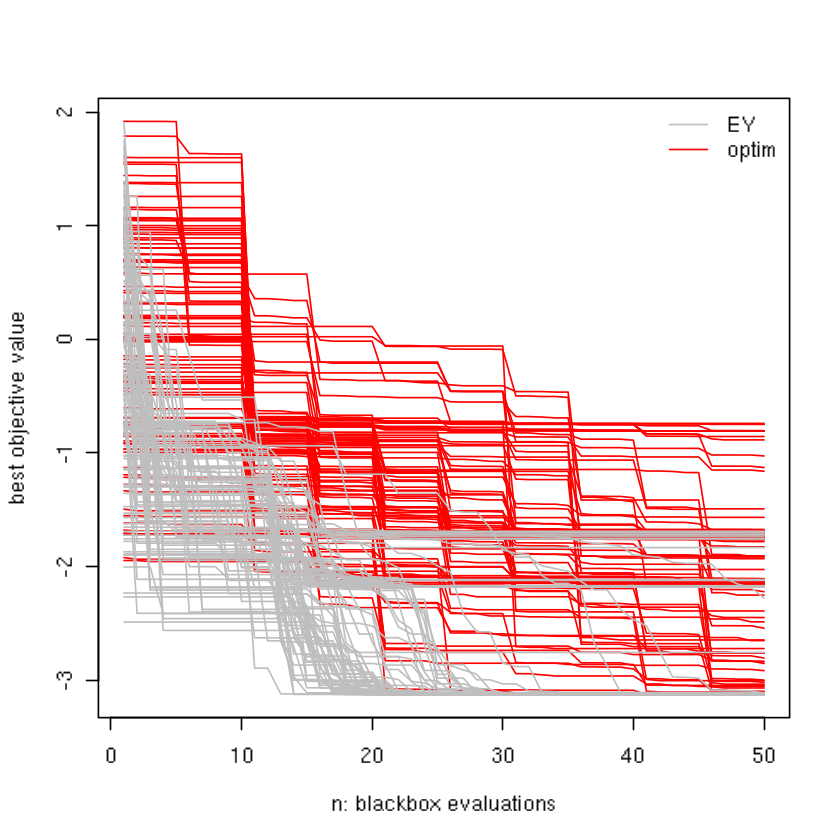

In [52]:
matplot(t(prog.optim), type="l", col="red", lty=1, 
  xlab="n: blackbox evaluations", ylab="best objective value")
matlines(t(prog), type="l", col="gray", lty=1)
legend("topright", c("EY", "optim"), col=c("gray", "red"), lty=1, bty="n")

## 7.2.1 Classic EI illustration

In [53]:
x <- c(1, 2, 3, 4, 12)
y <- c(0, -1.75, -2, -0.5, 5)

In [54]:
gpi <- newGP(matrix(x, ncol=1), y, d=10, g=1e-8)
xx <- seq(0, 13, length=1000)
p <- predGP(gpi, matrix(xx, ncol=1), lite=TRUE)

In [72]:
m <- which.min(y)
fmin <- y[m]
d <- fmin - p$mean
s <- sqrt(p$s2)
dn <- d/s
ei <- d*pnorm(dn) + s* dnorm(dn)

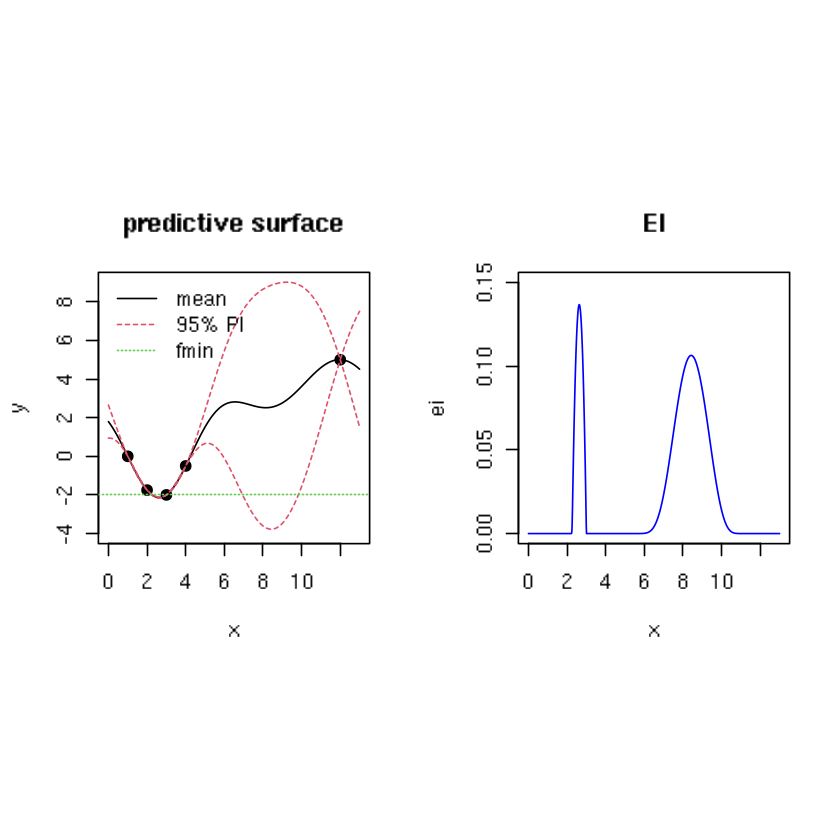

In [74]:
par(mfrow=c(1,2), pty="s")
plot(x, y, pch=19, xlim=c(0,13), ylim=c(-4,9), main="predictive surface")
lines(xx, p$mean)
lines(xx, p$mean + 2*sqrt(p$s2), col=2, lty=2)
lines(xx, p$mean - 2*sqrt(p$s2), col=2, lty=2)
abline(h=fmin, col=3, lty=3)
legend("topleft", c("mean", "95% PI", "fmin"), lty=1:3, col=1:3, bty="n")
plot(xx, ei, type="l", col="blue", main="EI", xlab="x", ylim=c(0,0.15))

In [75]:
mm <- which.max(ei)
x <- c(x, xx[mm])
y <- c(y, p$mean[mm])

In [76]:
updateGP(gpi, matrix(xx[mm], ncol=1), p$mean[mm])
p <- predGP(gpi, matrix(xx, ncol=1), lite=TRUE)
deleteGP(gpi)

In [77]:
m <- which.min(y)
fmin <- y[m]
d <- fmin - p$mean
s <- sqrt(p$s2)
dn <- d/s
ei <- d*pnorm(dn) + s*dnorm(dn)

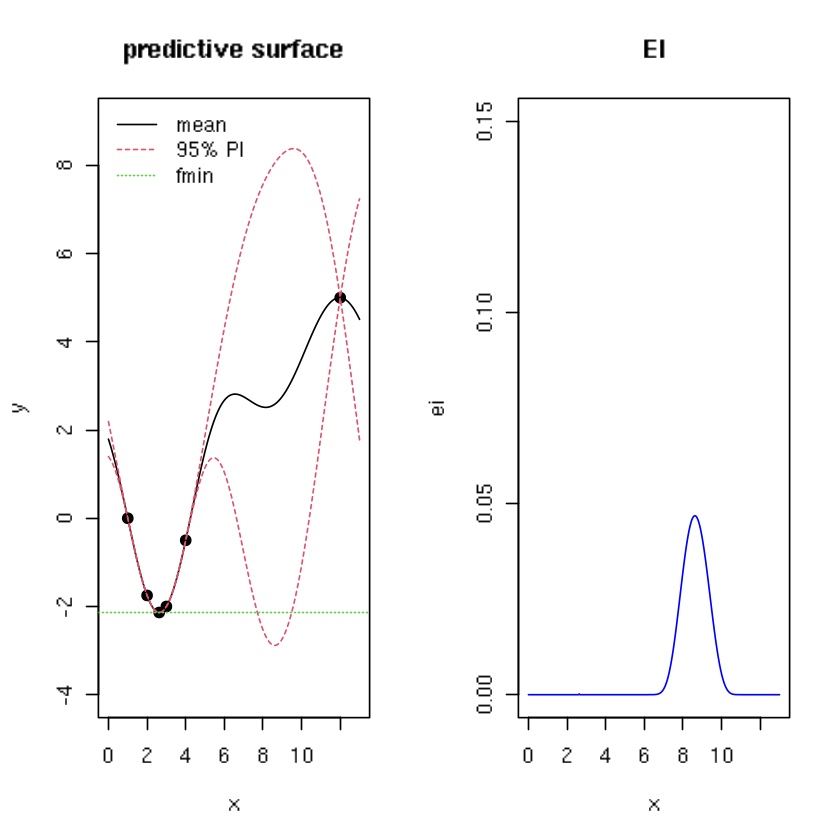

In [78]:
par(mfrow=c(1,2))
plot(x, y, pch=19, xlim=c(0,13), ylim=c(-4,9), main="predictive surface")
lines(xx, p$mean)
lines(xx, p$mean + 2*sqrt(p$s2), col=2, lty=2)
lines(xx, p$mean - 2*sqrt(p$s2), col=2, lty=2)
abline(h=fmin, col=3, lty=3)
legend("topleft", c("mean", "95% PI", "fmin"), lty=1:3, 
  col=1:3, bty="n")
plot(xx, ei, type="l", col="blue", main="EI", xlab="x", ylim=c(0,0.15))

In [79]:
EI <- function(gpi, x, fmin, pred=predGPsep)
 {
  if(is.null(nrow(x))) x <- matrix(x, nrow=1)
  p <- pred(gpi, x, lite=TRUE)
  d <- fmin - p$mean
  sigma <- sqrt(p$s2)
  dn <- d/sigma
  ei <- d*pnorm(dn) + sigma*dnorm(dn)
  return(ei)
 }

### 7.2.2 EI on our running example

In [80]:
obj.EI <- function(x, fmin, gpi, pred=predGPsep) 
  - EI(gpi, x, fmin, pred)

In [81]:
eps <- sqrt(.Machine$double.eps) ## used lots below

EI.search <- function(X, y, gpi, pred=predGPsep, multi.start=5, tol=eps)
 {
  m <- which.min(y)
  fmin <- y[m]
  start <- matrix(X[m,], nrow=1)
  if(multi.start > 1) 
    start <- rbind(start, randomLHS(multi.start - 1, ncol(X)))
  xnew <- matrix(NA, nrow=nrow(start), ncol=ncol(X)+1)
  for(i in 1:nrow(start)) {
    if(EI(gpi, start[i,], fmin) <= tol) { out <- list(value=-Inf); next }
    out <- optim(start[i,], obj.EI, method="L-BFGS-B", 
      lower=0, upper=1, gpi=gpi, pred=pred, fmin=fmin)
    xnew[i,] <- c(out$par, -out$value)
  }
  solns <- data.frame(cbind(start, xnew))
  names(solns) <- c("s1", "s2", "x1", "x2", "val")
  solns <- solns[solns$val > tol,]
  return(solns)
}

In [82]:
X <- randomLHS(ninit, 2)
y <- f(X)
gpi <- newGPsep(X, y, d=0.1, g=1e-6, dK=TRUE)
da <- darg(list(mle=TRUE, max=0.5), randomLHS(1000, 2))

In [83]:
solns <- EI.search(X, y, gpi)
m <- which.max(solns$val)
maxei <- solns$val[m]

Warning message in arrows(solns$s1, solns$s2, solns$x1, solns$x2, length = 0.1):
“zero-length arrow is of indeterminate angle and so skipped”


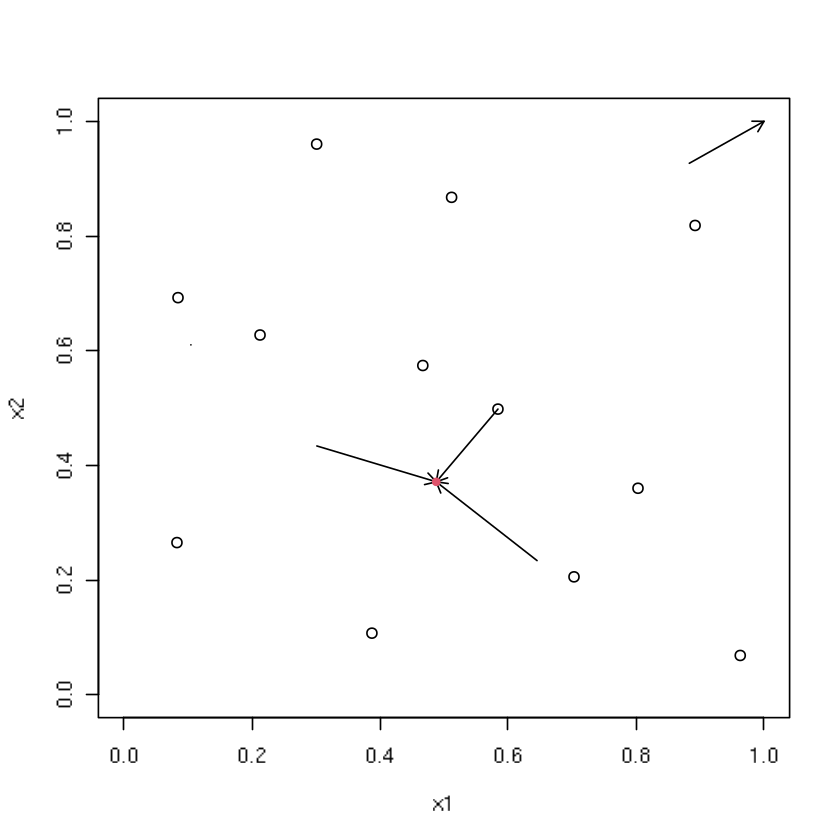

In [85]:
plot(X, xlab="x1", ylab="x2", xlim=c(0,1), ylim=c(0,1))
arrows(solns$s1, solns$s2, solns$x1, solns$x2, length=0.1)
points(solns$x1[m], solns$x2[m], col=2, pch=20)

In [86]:
xnew <- as.matrix(solns[m,3:4])
X <- rbind(X, xnew)
y <- c(y, f(xnew))
updateGPsep(gpi, xnew, y[length(y)])
mle <- mleGPsep(gpi, param="d", tmin=da$min, tmax=da$max, ab=da$ab)

In [87]:
solns <- EI.search(X, y, gpi)
m <- which.max(solns$val)
maxei <- c(maxei, solns$val[m])
xnew <- as.matrix(solns[m,3:4])
X <- rbind(X, xnew)
y <- c(y, f(xnew))
updateGPsep(gpi, xnew, y[length(y)])
mle <- mleGPsep(gpi, param="d", tmin=da$min, tmax=da$max, ab=da$ab)

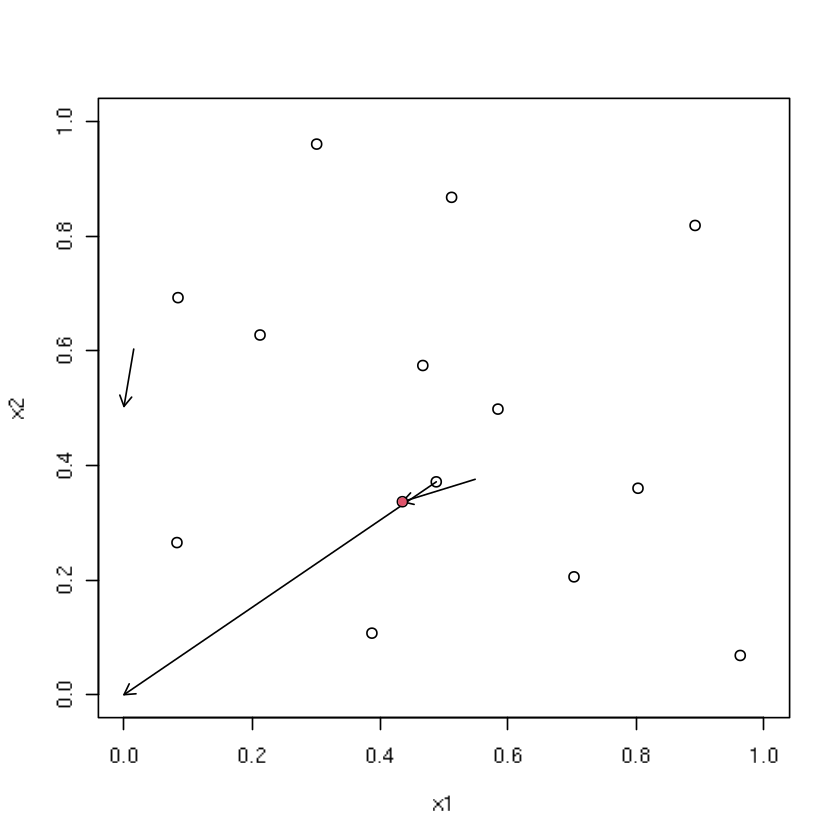

In [88]:
plot(X, xlab="x1", ylab="x2", xlim=c(0,1), ylim=c(0,1))
arrows(solns$s1, solns$s2, solns$x1, solns$x2, length=0.1)
points(solns$x1[m], solns$x2[m], col=2, pch=20)

In [89]:
for(i in nrow(X):end) {
  solns <- EI.search(X, y, gpi)
  m <- which.max(solns$val)
  maxei <- c(maxei, solns$val[m])
  xnew <- as.matrix(solns[m,3:4])
  ynew <- f(xnew)
  X <- rbind(X, xnew)
  y <- c(y, ynew)
  updateGPsep(gpi, xnew, y[length(y)])
  mle <- mleGPsep(gpi, param="d", tmin=da$min, tmax=da$max, ab=da$ab)
}
deleteGPsep(gpi)

In [90]:
prog.ei <- bov(y)

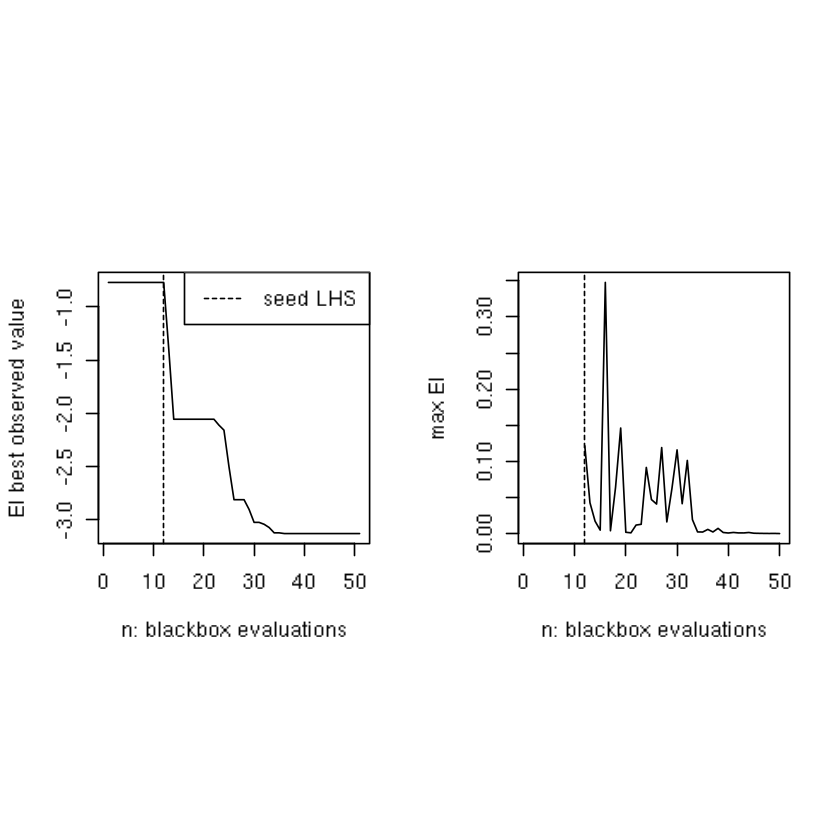

In [92]:
par(mfrow=c(1,2), pty="s")
plot(prog.ei, type="l", xlab="n: blackbox evaluations", 
  ylab="EI best observed value")
abline(v=ninit, lty=2)
legend("topright", "seed LHS", lty=2)
plot(ninit:end, maxei, type="l",  xlim=c(1,end), 
  xlab="n: blackbox evaluations", ylab="max EI")
abline(v=ninit, lty=2)

In [93]:
optim.EI <- function(f, ninit, end)
 {
  ## initialization
  X <- randomLHS(ninit, 2)
  y <- f(X)
  gpi <- newGPsep(X, y, d=0.1, g=1e-6, dK=TRUE)
  da <- darg(list(mle=TRUE, max=0.5), randomLHS(1000, 2))
  mleGPsep(gpi, param="d", tmin=da$min, tmax=da$max, ab=da$ab)
    
  ## optimization loop of sequential acquisitions
  maxei <- c()
  for(i in (ninit+1):end) {
    solns <- EI.search(X, y, gpi)
    m <- which.max(solns$val)
    maxei <- c(maxei, solns$val[m])
    xnew <- as.matrix(solns[m,3:4])
    ynew <- f(xnew)
    updateGPsep(gpi, xnew, ynew)
    mleGPsep(gpi, param="d", tmin=da$min, tmax=da$max, ab=da$ab)
    X <- rbind(X, xnew)
    y <- c(y, ynew)
  }

  ## clean up and return
  deleteGPsep(gpi)
  return(list(X=X, y=y, maxei=maxei))
 }

In [94]:
reps <- 100
prog.ei <- matrix(NA, nrow=reps, ncol=end)
for(r in 1:reps) {
  os <- optim.EI(f, ninit, end)
  prog.ei[r,] <- bov(os$y)
}

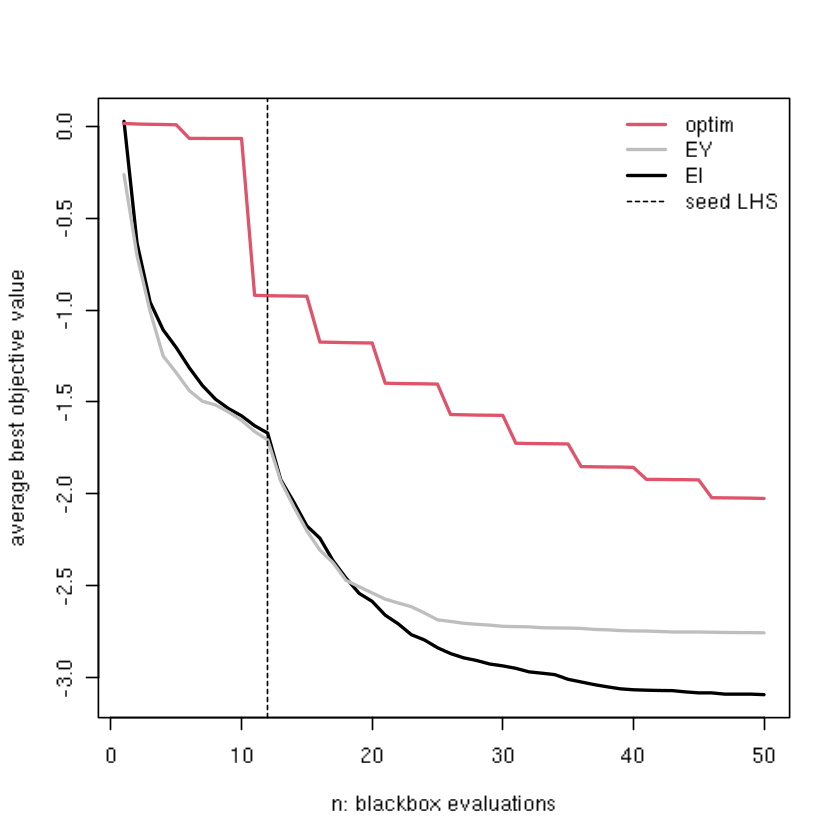

In [95]:
plot(colMeans(prog.ei), col=1, lwd=2, type="l", 
  xlab="n: blackbox evaluations", ylab="average best objective value")
lines(colMeans(prog), col="gray", lwd=2)
lines(colMeans(prog.optim, na.rm=TRUE), col=2, lwd=2)
abline(v=ninit, lty=2)
legend("topright", c("optim", "EY", "EI", "seed LHS"), 
  col=c(2, "gray", 1, 1), lwd=c(2,2,2,1), lty=c(1,1,1,2), 
  bty="n")

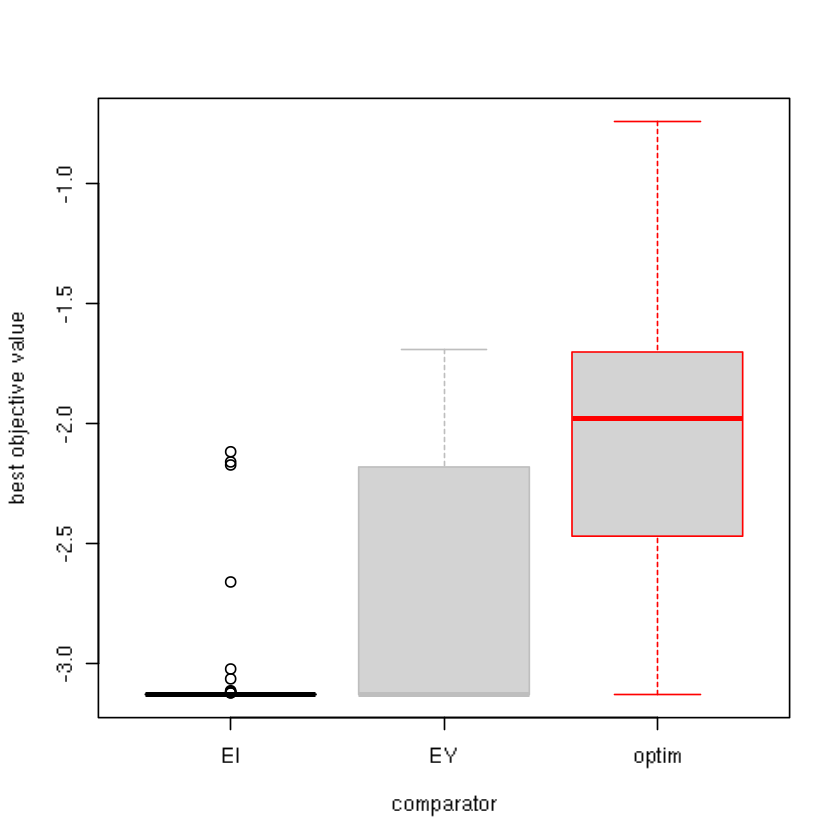

In [96]:
boxplot(prog.ei[,end], prog[,end], prog.optim[,end], 
  names=c("EI", "EY", "optim"), border=c("black", "gray", "red"), 
  xlab="comparator", ylab="best objective value")

### 7.2.5 Illustrating conditional improvement and noise

In [97]:
fsindn <- function(x)
 sin(x) - 2.55*dnorm(x,1.6,0.45)
X <- matrix(c(0, 0.3, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.5, 
  2.8, 3.1, 3.4, 3.7, 4.4, 5.3, 5.7, 6.1, 6.5, 7), ncol=1)
y <- fsindn(X) + rnorm(length(X), sd=0.15)

In [98]:
gpi <- newGP(X, y, d=0.1, g=0.1*var(y), dK=TRUE)
mle <- jmleGP(gpi)

In [99]:
XX <- matrix(seq(0, 7, length=201), ncol=1)
pY <- predGP(gpi, XX, lite=TRUE)
pf <- predGP(gpi, XX, lite=TRUE, nonug=TRUE)

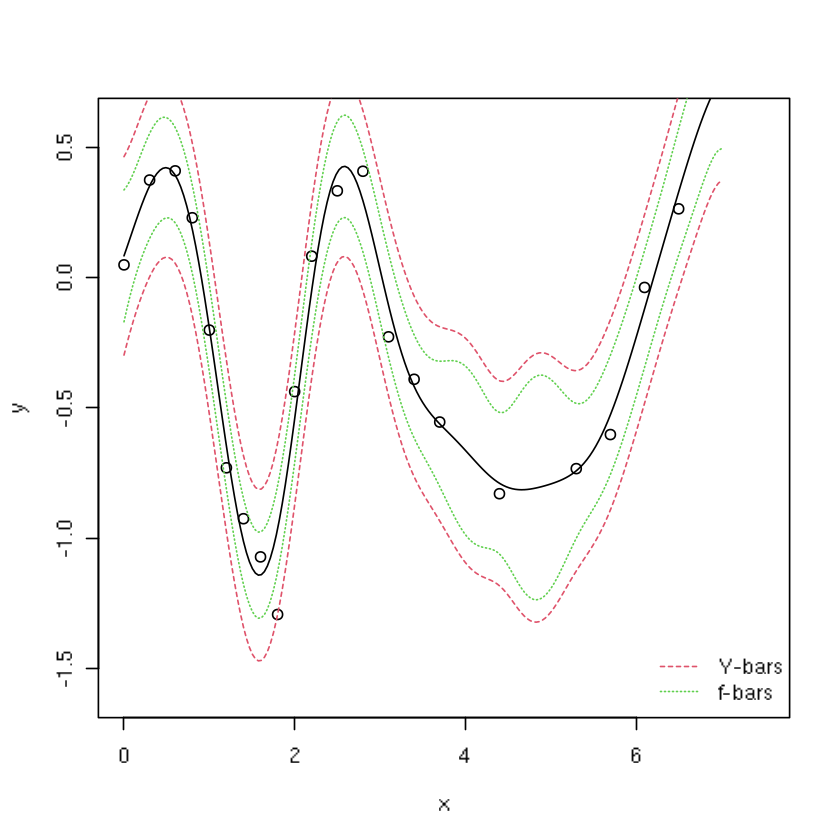

In [100]:
plot(X, y, xlab="x", ylab="y", ylim=c(-1.6,0.6), xlim=c(0,7.5))
lines(XX, pY$mean)
lines(XX, pY$mean + 1.96*sqrt(pY$s2), col=2, lty=2)
lines(XX, pY$mean - 1.96*sqrt(pY$s2), col=2, lty=2)
lines(XX, pf$mean + 1.96*sqrt(pf$s2), col=3, lty=3)
lines(XX, pf$mean - 1.96*sqrt(pf$s2), col=3, lty=3)
legend("bottomright", c("Y-bars", "f-bars"), col=2:4, lty=2:3, bty="n")

In [101]:
fmin <- min(predGP(gpi, X, lite=TRUE)$mean)
ei <- EI(gpi, XX, fmin, pred=predGP)
ieci <- ieciGP(gpi, XX, fmin)
predGPnonug <- predGP
formals(predGPnonug)$nonug <- TRUE
ei.f <- EI(gpi, XX, fmin, pred=predGPnonug)
ieci.f <- ieciGP(gpi, XX, fmin, nonug=TRUE)

In [102]:
ei <- scale(ei, min(ei), max(ei) - min(ei))
ei.f <- scale(ei.f, min(ei.f), max(ei.f) - min(ei.f))
ieci <- scale(ieci, min(ieci), max(ieci) - min(ieci))
ieci.f <- scale(ieci.f, min(ieci.f), max(ieci.f) - min(ieci.f))

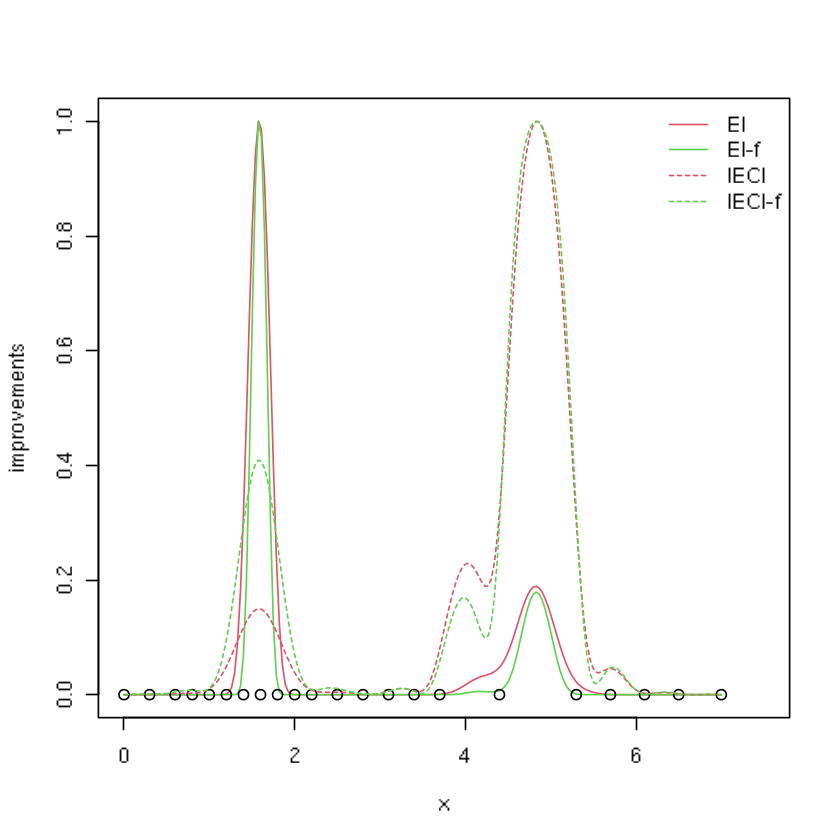

In [103]:
plot(XX, ei, type="l", ylim=c(0, 1), xlim=c(0,7.5), col=2, lty=1, 
  xlab="x", ylab="improvements")
lines(XX, ei.f, col=3, lty=1)
points(X, rep(0, nrow(X)))
lines(XX, 1-ieci, col=2, lty=2)
lines(XX, 1-ieci.f, col=3, lty=2)
legend("topright", c("EI", "EI-f", "IECI", "IECI-f"), lty=c(1,1,2,2), 
  col=c(2,3,2,3), bty="n")

## 7.3 Optimization under constraints